In [1]:
data_path = '../data/'

# Figure 1 : 
## Zonal mean and surface anomalies associated with positive SAM and timeseries.

In [2]:
import matplotlib
import pandas as pd
import numpy as np
import xarray as xr
import netCDF4
from matplotlib import pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import BoundaryNorm
import cartopy.crs as ccrs
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter

from scipy.stats import linregress
# Function to apply linear regression at each grid point
def linregress_at_gridpoint(x, y):
    slope, intercept, r_value, p_value, std_err = linregress(x, y)
    return slope, p_value

def regress_3d(index, field):
    results = xr.apply_ufunc(linregress_at_gridpoint, 
                             index,
                             field,
                             input_core_dims=[['time'], ['time']],
                             output_core_dims=[[], []],
                             vectorize=True,
                             dask='parallelized',
                             output_dtypes=[float, float])
    return results[0], results[1] 

from matplotlib.colors import LinearSegmentedColormap
# Function to create a modified colormap
def create_modified_rdbu_cmap():
    cmap = plt.get_cmap('RdBu_r')
    colors = cmap(np.linspace(0, 1, 256))
    middle = len(colors) // 2
    white_range = 10  
    colors[middle-white_range:middle+white_range] = [1, 1, 1, 1]  
    return LinearSegmentedColormap.from_list('ModifiedRdBu_r', colors)
modified_rdbu_cmap = create_modified_rdbu_cmap()

# 1) Read data and calculate regression

In [3]:
SAM = pd.read_csv(data_path+"SAM_indices_annual_from_monthly_1979_2023.csv", index_col = 0)
SAM.corr(method = 'pearson', min_periods=1, numeric_only = True)

,SAM_GW,SAM_Marshall_station,SAM_Marshall_offset,CPC_AAO,CPC_AAO_offset,s_pc_EOF1,s_pc_EOF2
SAM_GW,1.000000,0.877945,0.877945,0.920936,0.920936,0.868458,0.674714
SAM_Marshall_station,0.877945,1.000000,1.000000,0.898360,0.898360,0.834304,0.474829
SAM_Marshall_offset,0.877945,1.000000,1.000000,0.898360,0.898360,0.834304,0.474829
CPC_AAO,0.920936,0.898360,0.898360,1.000000,1.000000,0.865392,0.492349
CPC_AAO_offset,0.920936,0.898360,0.898360,1.000000,1.000000,0.865392,0.492349
s_pc_EOF1,0.868458,0.834304,0.834304,0.865392,0.865392,1.000000,0.426894
s_pc_EOF2,0.674714,0.474829,0.474829,0.492349,0.492349,0.426894,1.000000


In [4]:
SAM_GW = xr.open_dataset(data_path+'SAM_GW_1m_1979-2023.nc', decode_times=True).SAM
# we standardize the SAM index for the regression to make the results relative to 1std of SAM change
index = (SAM_GW - SAM_GW.mean('time'))/(SAM_GW.std('time'))

field = xr.open_dataset(data_path+'msl_anomaly.nc', decode_times=True).msl.rename({'latitude':'lat','longitude':'lon'})
MSLPreg = regress_3d(index, field)
fieldu = xr.open_dataset(data_path+'u850_anomaly.nc', decode_times=True).__xarray_dataarray_variable__
Ureg = regress_3d(index, fieldu)
fieldv = xr.open_dataset(data_path+'v850_anomaly.nc', decode_times=True).__xarray_dataarray_variable__
Vreg = regress_3d(index, fieldv)

In [5]:
regslp = MSLPreg[0].where(MSLPreg[1]<0.05)
regu = Ureg[0].where((abs(Ureg[0])>0.1) & (Ureg[1]<0.05))
regv = Vreg[0].where((abs(Ureg[0])>0.1) & (Vreg[1]<0.05))

In [6]:
#zmU = xr.open_dataset('/scratch/eg3/gab563/zu_ERA5_1m_1979-2021_withera1_2000-2006.nc', decode_times=True).u.sel(latitude=slice(0,-90))
#zmUreg = regress_3d(index.sel(time=slice('1979','2021')), zmU)
#zmUmean = zmU.mean('time')
#zmUreg = zmUreg[0]
#zmUreg.to_netcdf('/g/data/v45/SAMworkshop2024/data/zmUreg.nc')
#zmUmean.to_netcdf('/g/data/v45/SAMworkshop2024/data/zmUreg.nc', mode='a')

# 2) PLOT

/jobfs/152389810.gadi-pbs/ipykernel_489790/3191754310.py:14: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax1.contour(lat, plevs, u.zmUmean.data, colors='black', vmin=-30, vmax=30, levels=np.linspace(-30, 30, 16), linewidth=0.75, alpha=0.25)
/jobfs/152389810.gadi-pbs/ipykernel_489790/3191754310.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(['90°S','80°S','70°S','60°S','50°S','40°S','30°S','20°S','10°S','0°'], fontsize=10)
/jobfs/152389810.gadi-pbs/ipykernel_489790/3191754310.py:58: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.97])


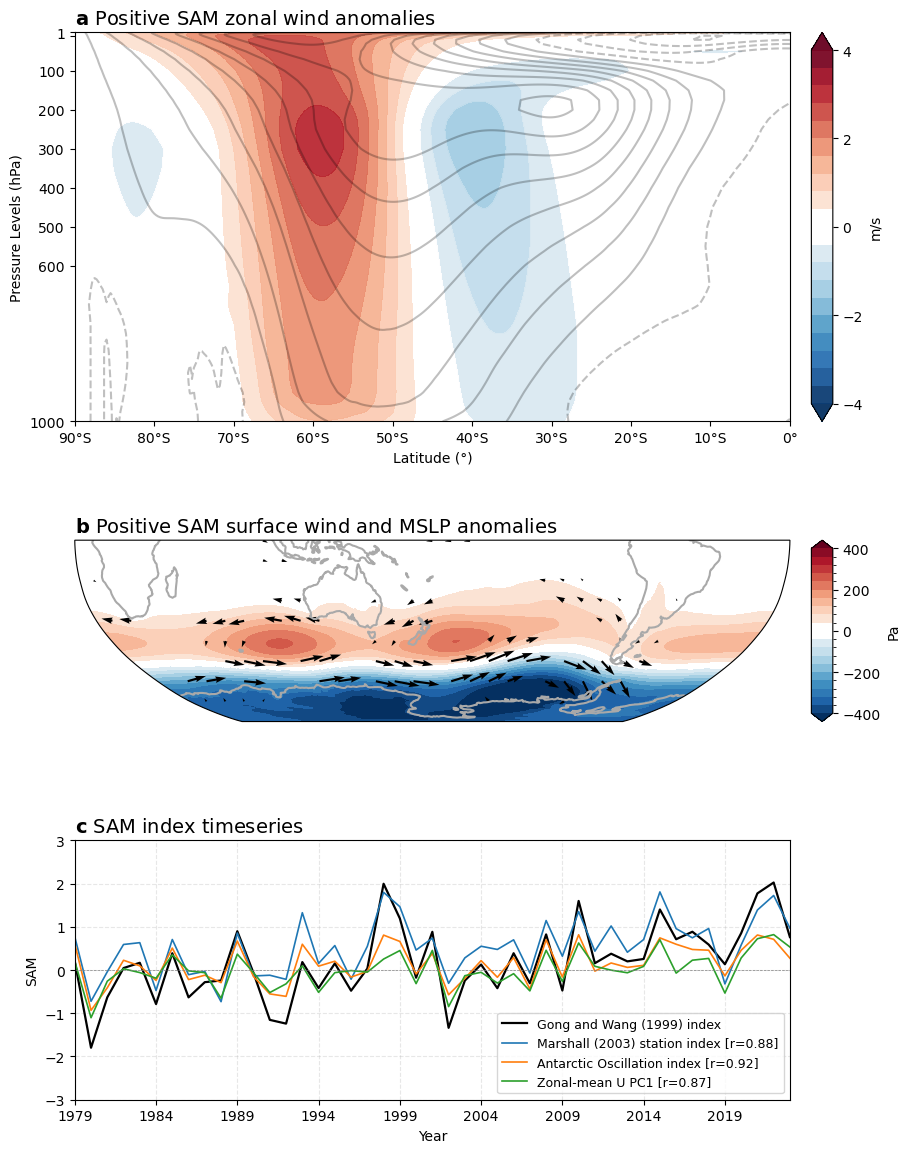

In [7]:
ds = xr.open_dataset(data_path+'reg_msl_wind.nc')
u = xr.open_dataset(data_path+'reg_u.nc')

fig = plt.figure(figsize=(10, 12))  
gs = gridspec.GridSpec(ncols=4, nrows=3, figure=fig, height_ratios=[1.5,1.5,1], 
                       width_ratios=[0.15,1,1,0.15])

# Subplot 1: Contour Plot (Top Row)
ax1 = fig.add_subplot(gs[0, 1:3])  
ax1.set_title(r'$\bf{a}$ Positive SAM zonal wind anomalies', loc='left', fontsize=14)
stats = u.zmUreg
lat, plevs = np.meshgrid(stats.latitude, stats.level)
CS = ax1.contourf(lat, plevs, stats.data, cmap=modified_rdbu_cmap, extend='both', vmin=-4, vmax=4, levels=np.linspace(-4, 4, 21), alpha=0.95)
ax1.contour(lat, plevs, u.zmUmean.data, colors='black', vmin=-30, vmax=30, levels=np.linspace(-30, 30, 16), linewidth=0.75, alpha=0.25)
ax1.set_ylim([1000, 1])
ax1.set_yticks([1000, 600, 500, 400, 300, 200, 100, 10, 1])
ax1.set_yticklabels(['1000', '600', '500', '400', '300', '200', '100', '', '1'], fontsize=10)
ax1.set_xticklabels(['90°S','80°S','70°S','60°S','50°S','40°S','30°S','20°S','10°S','0°'], fontsize=10)
ax1.set_xlabel('Latitude (°)', fontsize=10)
ax1.set_ylabel('Pressure Levels (hPa)', fontsize=10)
cb_ax1 = inset_axes(ax1, width="3%", height="100%", loc='center left', bbox_to_anchor=(1.03, 0., 1, 1), bbox_transform=ax1.transAxes, borderpad=0)
cbar1 = plt.colorbar(CS, cax=cb_ax1, orientation='vertical', ticks=[-4, -2, 0, 2, 4])
cbar1.set_label('m/s', fontsize=10)

# Subplot 2: MSLP and wind regression Map (Middle Row)
ax2 = fig.add_subplot(gs[1, 1:3], projection=ccrs.Robinson(central_longitude=180))
ax2.set_title(r'$\bf{b}$ Positive SAM surface wind and MSLP anomalies', loc='left', fontsize=14)
mp = regslp.plot.contourf(ax=ax2, vmin=-400, vmax=400, extend='both', levels=np.linspace(-400, 400, 21), cmap=modified_rdbu_cmap, transform=ccrs.PlateCarree(), add_colorbar=False)
step = 1  
quiver = ds.isel(latitude=slice(None, None, step), longitude=slice(None, None, step))
ax2.quiver(quiver.longitude, quiver.latitude, quiver['regu'], quiver['regv'], scale=50, transform=ccrs.PlateCarree(), regrid_shape=10)
ax2.coastlines('110m', color='darkgrey', linewidth=1.5)
cb_ax2 = inset_axes(ax2, width="3%", height="100%", loc='center left', bbox_to_anchor=(1.03, 0., 1, 1), bbox_transform=ax2.transAxes, borderpad=0)
cbar2 = plt.colorbar(mp, cax=cb_ax2, orientation='vertical', ticks=[-400, -200, 0, 200, 400])
cbar2.set_label('Pa', fontsize=10)

# Subplot 3: Time Series Plot (Bottom Row)
ax3 = fig.add_subplot(gs[2,1:3])
ax3.set_title(r'$\bf{c}$ SAM index timeseries', loc='left', fontsize=14)
Year = SAM.index
GW = SAM['SAM_GW']
Marshall = SAM['SAM_Marshall_offset']
AAO = SAM['CPC_AAO_offset']
zmU = SAM['s_pc_EOF1']
ax3.plot(Year, GW, color='black', linewidth=1.6, label='Gong and Wang (1999) index')
ax3.plot(Year, Marshall, color='#1f77b4', linewidth=1.2, label='Marshall (2003) station index [r=0.88]')
ax3.plot(Year, AAO, color='#ff7f0e', linewidth=1.2, label='Antarctic Oscillation index [r=0.92]')
ax3.plot(Year, zmU, color='#2ca02c', linewidth=1.2, label='Zonal-mean U PC1 [r=0.87]')
ax3.axhline(0, color='grey', linestyle='--', linewidth=0.5)
ax3.legend(loc='lower right', fontsize=9)
ax3.set_xlim([1979, 2023])
ax3.set_xticks(np.arange(1979, 2024, 5))
ax3.set_yticks(np.arange(-3, 4, 1))
ax3.grid(which='major', alpha=0.3, linestyle='dashed')
ax3.set_ylabel("SAM", fontsize=10)
ax3.set_xlabel("Year", fontsize=10)

plt.tight_layout(rect=[0, 0, 1, 0.97]) 
plt.savefig('Fig1.pdf', dpi=300, bbox_inches='tight')